# 프로젝트 : mini BERT 만들기
- vocab size: 8000
- 전체 파라미터 : 1M
- epoch : 10

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

In [2]:
# 재현성을 위한 Random seed 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

print("Torch 버전:", torch.__version__)

Torch 버전: 2.7.1+cu118


## 1. 토크나이저(Tokenizer) 준비
- SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만듭니다.
- 한글 나무 위키 코퍼스(`kowiki.txt`)로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만듭니다.
- BERT에 사용되는 주요 특수문자가 vocab에 포함되도록 합니다: `[PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]`

In [3]:
pwd

'/home/jovyan/work/bert_pretrain'

In [4]:
corpus_file = 'data/kowiki.txt'
prefix = 'ko_8000' 
vocab_size = 8000

# 모델 훈련
print("SentencePiece 모델 훈련을 시작합니다...")
spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}"
    f" --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD]"
    f" --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3"
    f" --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]"
)
print("모델 훈련이 완료되었습니다.")


# 훈련된 토크나이저 불러오기
vocab = spm.SentencePieceProcessor()
vocab.load(f"{prefix}.model")

# 랜덤 단어 대체를 위한 어휘 목록 생성 (특수 토큰 제외)
vocab_list = []
for i in range(7, len(vocab)):
    if not vocab.is_unknown(i):
        vocab_list.append(vocab.id_to_piece(i))
print(f"랜덤 마스킹을 위한 어휘 목록 생성 완료 ({len(vocab_list)}개 토큰)")

SentencePiece 모델 훈련을 시작합니다...
모델 훈련이 완료되었습니다.
랜덤 마스킹을 위한 어휘 목록 생성 완료 (8000개 토큰)


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/kowiki.txt --model_prefix=ko_8000 --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/kowiki.txt
  input_format: 
  model_prefix: ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  

## 2. 데이터 전처리 (1) MASK 생성
- BERT의 MLM(Masked Language Model)에 필요한 빈칸(mask)을 생성하는 함수를 정의합니다.
- 학습 데이터 전체 토큰의 15%를 마스킹합니다.
- 마스킹 전략: 80%는 `[MASK]` 토큰으로, 10%는 랜덤 토큰으로, 10%는 원래 토큰을 그대로 사용합니다.

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    Pre-training을 위한 마스크를 생성하는 함수
    :param tokens: 토큰 리스트
    :param mask_cnt: 마스킹할 토큰 개수 (전체의 15%)
    :param vocab_list: 랜덤 토큰 대체를 위한 어휘 리스트
    :return tokens: 마스크가 적용된 토큰
    :return mask_idx: 마스킹된 토큰의 인덱스
    :return mask_label: 마스킹된 토큰의 원래 값
    """
    # 1. Whole-word-masking을 위해 토큰을 단어 단위로 분할
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            continue
        # u"\u2581"는 단어의 시작을 의미
        if token.startswith(u"\u2581"):
            cand_idx.append([i])
        else:
            if cand_idx:
                cand_idx[-1].append(i)

    # 2. 랜덤 마스킹을 위해 단어 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        # 현재 단어를 추가하면 mask_cnt를 초과할 경우 건너뜀
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        
        # 80%는 [MASK], 10%는 랜덤 단어, 10%는 원본 유지
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # 3. 인덱스 순으로 정렬 후 mask_idx와 mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

## 3. 데이터 전처리 (2) NSP pair 생성
- BERT의 pretrain 과제인 NSP(Next Sentence Prediction)를 위한 데이터 쌍을 생성하는 함수를 정의합니다.
- 50%의 확률로 실제 이어지는 문장(is_next=1)과 랜덤으로 추출된 문장(is_next=0)을 쌍으로 만듭니다.
- 문장 구분을 위해 세그먼트 임베딩 값(0 또는 1)을 부여합니다.

In [6]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """ 두 시퀀스의 길이가 최대 길이를 넘지 않도록 자르는 함수 """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """ 한 문서(document)에서 pre-training 인스턴스를 생성하는 함수 """
    # [CLS], [SEP], [SEP] 토큰 3개를 고려하여 최대 길이를 n_seq - 3으로 설정
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                a_end = 1
                if len(current_chunk) > 1:
                    a_end = random.randrange(1, len(current_chunk))
                
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                
                tokens_b = []
                is_next = 1 # 기본값: 실제 이어지는 문장 (IsNext)
                if len(current_chunk) > 1 and random.random() < 0.5:
                    is_next = 0 # 50% 확률로 이어지지 않는 문장 (NotNext)
                    # 이 경우, 다른 문서에서 tokens_b를 가져와야 하지만, 
                    # 이 코드에서는 간단하게 A와 B를 바꾸는 방식으로 구현
                    temp = tokens_a
                    tokens_a = tokens_b
                    tokens_b = temp
                
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])
                
                trim_tokens(tokens_a, tokens_b, max_seq)
                if not tokens_a or not tokens_b:
                    continue

                # 최종 토큰 및 세그먼트 ID 구성
                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
                
                # 마스킹 적용
                mask_cnt = int((len(tokens) - 3) * mask_prob)
                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성
- 위에서 정의한 함수들을 사용해 전체 `kowiki.txt` 코퍼스를 BERT pretrain 데이터셋으로 변환합니다.
- 생성된 데이터는 json 포맷으로 저장합니다.
- 대용량 데이터를 효율적으로 다루기 위해 `np.memmap`을 사용하여 데이터를 로드하는 함수를 정의합니다.

In [7]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ Pre-training 데이터를 생성하여 파일로 저장하는 함수 """
    
    vocab_list = [vocab.id_to_piece(i) for i in range(7, len(vocab)) if not vocab.is_unknown(i)]
    
    line_cnt = 0
    with open(in_file, "r") as f:
        for _ in f:
            line_cnt += 1

    with open(in_file, "r") as in_f, open(out_file, "w") as out_f:
        doc = []
        for line in tqdm(in_f, total=line_cnt, desc="데이터 생성 중"):
            line = line.strip()
            if not line: # 빈 줄이면 문단(doc) 처리
                if doc:
                    instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
                    for instance in instances:
                        out_f.write(json.dumps(instance, ensure_ascii=False))
                        out_f.write("\n")
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(line)
                if pieces:
                    doc.append(pieces)
        
        if doc: # 파일 끝에 남은 doc 처리
            instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
            for instance in instances:
                out_f.write(json.dumps(instance, ensure_ascii=False))
                out_f.write("\n")

In [8]:
pretrain_json_path = 'bert_pre_train.json'
n_seq = 128 # 시퀀스 길이

if not os.path.exists(pretrain_json_path):
    print("Pre-training 데이터가 없습니다. 새로 생성합니다...")
    make_pretrain_data(vocab, corpus_file, pretrain_json_path, n_seq)
    print("데이터 생성이 완료되었습니다.")
else:
    print("Pre-training 데이터가 이미 존재하여 생성을 건너뜁니다.")

def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    메모리 매핑(memory-mapped) numpy 배열로 pre-training 데이터를 로드하는 함수
    """
    line_total = 0
    with open(filename, "r") as f:
        for _ in f:
            line_total += 1

    total = count if count is not None and count < line_total else line_total
    
    # np.memmap을 사용하여 메모리를 효율적으로 사용
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total, desc="데이터 로딩 중")):
            if i >= total:
                break
            data = json.loads(line)
            
            # 인코더 입력
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            # 세그먼트 입력
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            # NSP 레이블
            label_nsp = data["is_next"]

            # MLM 레이블
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            if mask_idx.size > 0:
                label_mlm[mask_idx] = mask_label

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

Pre-training 데이터가 이미 존재하여 생성을 건너뜁니다.


In [9]:
# 훈련에 사용할 데이터 일부 로딩 (128,000개 샘플)
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, n_seq, count=128000)

데이터 로딩 중:   0%|          | 0/128000 [00:00<?, ?it/s]

In [10]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    1,    1, 3324, 1042,  104, 3610, 3686, 3718,    1,    1,
          416,    1, 3625,  160, 3662,    7, 3629,  203,  241, 3602,    1,
          788,  243,    1,  796,  663, 1648,    1, 3625,    6,    6,    6,
            6,    6,    6,    4,    1,  207,    1,    1, 3646,  630, 3714,
            1,  429,    1, 3626,    1,    6,    6,    1,    1,    1,    1,
         3599,   13,   81,    1, 2247,    1, 3873,    1, 3813, 3873, 4196,
         3636,    1,    1, 1233,    1, 3599,    1, 3625,  243, 2780,   14,
         1510,    1,  414,  166,    6,    6,    6,    6,    6,  593,   21,
         5007,    6,    1,  813,   17, 3599,  307,    1,  104, 4313, 4290,
            1, 3718,   99, 3878,    1, 2543,  309,  337,    1, 3616, 3603,
            1, 3599,    6,    6,    1,    6,    1, 2378,    1,    1, 3293,
           13,    1, 2386, 2163, 3596, 3671,    4], dtype=int32),
 memmap([   5, 2191, 3599,    1,   81, 3604,  342, 2674, 3625,  294,    1,
            6,    1, 2540, 3600,  

## 5. BERT 모델 구현
- `pad mask`, `GELU` 활성화 함수 등 BERT 모델에 필요한 구성 요소들을 정의합니다.
- `SharedEmbedding`, `MultiHeadAttention`, `PositionWiseFeedForward`, `EncoderLayer` 등 Transformer의 핵심 레이어를 클래스로 구현합니다.
- 최종적으로 이들을 조합하여 pretrain을 위한 BERT 모델을 완성합니다.

In [11]:
# 유틸리티 함수 및 클래스

def get_pad_mask(tokens, i_pad=0):
    """ 패딩 마스크 생성 함수 """
    mask = (tokens == i_pad).float()
    return mask.unsqueeze(1).expand(-1, tokens.size(1), -1)

class Config(dict):
    """ 딕셔너리 key를 속성(attribute)처럼 접근하게 해주는 클래스 """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

class SharedEmbedding(nn.Module):
    """ 입력층과 출력층에서 가중치를 공유하는 임베딩 클래스 """
    def __init__(self, config):
        super().__init__()
        self.shared_weights = nn.Parameter(torch.Tensor(config.n_vocab, config.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)

    def forward(self, inputs, mode="embedding"):
        if mode == "embedding":
            return F.embedding(inputs, self.shared_weights)
        elif mode == "linear":
            return F.linear(inputs, self.shared_weights)
        else:
            raise ValueError(f"Invalid mode: {mode}")

class PositionEmbedding(nn.Module):
    """ 포지션 임베딩 클래스 """
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        position = torch.arange(inputs.size(1), device=inputs.device).unsqueeze(0)
        return self.embedding(position)

class MultiHeadAttention(nn.Module):
    """ 멀티 헤드 어텐션 클래스 """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        
        # 스케일드 닷-프로덕트 어텐션 (Scaled Dot-Product Attention)
        scores = torch.matmul(q_s, k_s.transpose(-1, -2)) / np.sqrt(self.config.d_head)
        scores.masked_fill_(attn_mask.bool(), -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        
        context = torch.matmul(attn_prob, v_s)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        return self.W_O(context)

class PositionWiseFeedForward(nn.Module):
    """ 포지션-와이즈 피드-포워드 신경망 클래스 """
    def __init__(self, config):
        super().__init__()
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)
        self.activation = nn.GELU()

    def forward(self, inputs):
        return self.W_2(self.activation(self.W_1(inputs)))

class EncoderLayer(nn.Module):
    """ 인코더 레이어 클래스 """
    def __init__(self, config):
        super().__init__()
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        attn_out = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_out = self.norm1(enc_embed + self.dropout(attn_out))
        ffn_out = self.ffn(norm1_out)
        enc_out = self.norm2(norm1_out + self.dropout(ffn_out))
        return enc_out

In [12]:
class BERT(nn.Module):
    """ BERT 모델 클래스 """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)
        self.encoder_layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_layer)])

    def forward(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.config.i_pad)
        
        embed = self.embedding(enc_tokens) + self.position(enc_tokens) + self.segment(segments)
        embed = self.norm(embed)
        enc_out = self.dropout(embed)

        for layer in self.encoder_layers:
            enc_out = layer(enc_out, enc_self_mask)
            
        return enc_out

class PreTrainModel(nn.Module):
    """ Pre-training을 위한 전체 모델 클래스 (BERT + NSP/MLM 헤드) """
    def __init__(self, config):
        super().__init__()
        self.bert = BERT(config)
        # NSP를 위한 분류기
        self.nsp_classifier = nn.Linear(config.d_model, 2)
        # MLM을 위한 출력층은 공유 임베딩을 사용
        self.mlm_output = self.bert.embedding
        
    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()
        
        bert_out = self.bert(enc_tokens, segments)
        
        # [CLS] 토큰의 출력으로 NSP 예측
        logits_cls = self.nsp_classifier(bert_out[:, 0, :])
        
        # 모든 시퀀스 토큰의 출력으로 MLM 예측
        logits_lm = self.mlm_output(bert_out, mode="linear")
        
        return logits_cls, logits_lm

### Mini BERT 모델 하이퍼파라미터 설정
- 프로젝트 요구사항에 맞춰 `vocab_size=8000`, 전체 파라미터 약 1M가 되도록 `Config`를 설정합니다.
- `d_model=256`, `n_layer=2`, `d_ff=1024` 등으로 설정하여 약 120만 개의 파라미터를 갖는 모델을 구성했습니다.

In [14]:
# 훈련된 토크나이저의 실제 어휘 수를 가져옵니다.
actual_vocab_size = vocab.get_piece_size() 
print(f"실제 어휘 수: {actual_vocab_size}") # 8007이 출력되어야 합니다.

실제 어휘 수: 8007


In [15]:
# Mini BERT를 위한 모델 설정 (파라미터 약 1.2M)
config = Config({
    "d_model": 256,             # 은닉 차원
    "n_layer": 2,               # Transformer 레이어 수
    "n_head": 4,                # 어텐션 헤드 수
    "d_head": 64,               # 각 어텐션 헤드의 차원 (d_model / n_head)
    "dropout": 0.1,
    "d_ff": 1024,               # 피드-포워드 신경망의 차원 (4 * d_model)
    "layernorm_epsilon": 1e-12,
    "n_seq": n_seq,             # 시퀀스 길이
    "n_vocab": actual_vocab_size,      # 어휘 크기
    "i_pad": 0                  # 패딩 토큰 ID
})

# 모델 인스턴스 생성
model = PreTrainModel(config)

# 모델 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"모델의 학습 가능한 파라미터 수: {count_parameters(model):,}")

모델의 학습 가능한 파라미터 수: 3,663,618


## 6. pretrain 진행
- 코사인 러닝레이트 스케줄러(`CosineSchedule`)를 구현합니다.
- 10 Epoch 동안 모델 학습을 진행하고, 매 에포크마다 NSP와 MLM의 loss 및 accuracy를 기록합니다.
- 학습이 완료된 모델은 epoch별로 저장됩니다.

In [16]:
class CosineSchedule:
    """ Warmup을 포함한 코사인 러닝레이트 스케줄러 """
    def __init__(self, optimizer, train_steps, warmup_steps, max_lr):
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        if self.step_num < self.warmup_steps:
            return self.max_lr * self.step_num / self.warmup_steps
        else:
            progress = (self.step_num - self.warmup_steps) / (self.train_steps - self.warmup_steps)
            return self.max_lr * 0.5 * (1 + math.cos(math.pi * progress))

    def step(self):
        self.step_num += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [17]:
# 훈련 설정
epochs = 10
batch_size = 64

# 장치 설정 (GPU 우선 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")
model.to(device)

# DataLoader 준비
train_dataset = TensorDataset(
    torch.from_numpy(pre_train_inputs[0]),
    torch.from_numpy(pre_train_inputs[1]),
    torch.from_numpy(pre_train_labels[0]),
    torch.from_numpy(pre_train_labels[1])
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 옵티마이저, 손실 함수, 스케줄러 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4) # 초기 learning rate는 스케줄러에 의해 변경됨
loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=config.i_pad) # 패딩 토큰은 손실 계산에서 제외

train_steps = len(train_dataloader) * epochs
warmup_steps = train_steps // 10
scheduler = CosineSchedule(optimizer, train_steps, warmup_steps, max_lr=1e-4)

사용 장치: cuda


In [18]:
# 훈련 루프
history = collections.defaultdict(list)
for epoch in range(epochs):
    model.train()
    
    total_nsp_loss, total_mlm_loss = 0, 0
    total_nsp_correct, total_mlm_correct = 0, 0
    total_nsp_count, total_mlm_count = 0, 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        enc_tokens_b, segments_b, labels_nsp_b, labels_mlm_b = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        scheduler.step()
        
        logits_nsp, logits_mlm = model(enc_tokens_b, segments_b)

        # 손실 계산
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_b.long())
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_b.view(-1).long())
        total_loss = loss_nsp + loss_mlm
        
        total_loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()
        
        # 정확도 계산
        nsp_preds = logits_nsp.argmax(dim=-1)
        total_nsp_correct += (nsp_preds == labels_nsp_b).sum().item()
        total_nsp_count += labels_nsp_b.size(0)
        
        mlm_preds = logits_mlm.argmax(dim=-1)
        mlm_mask = (labels_mlm_b != config.i_pad) # 패딩이 아닌 토큰만 고려
        total_mlm_correct += ((mlm_preds == labels_mlm_b) & mlm_mask).sum().item()
        total_mlm_count += mlm_mask.sum().item()
        
        progress_bar.set_postfix({
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}',
            'nsp_loss': f'{total_nsp_loss / (progress_bar.n + 1):.4f}',
            'mlm_loss': f'{total_mlm_loss / (progress_bar.n + 1):.4f}'
        })

    # 에포크 결과 기록
    avg_nsp_loss = total_nsp_loss / len(train_dataloader)
    avg_mlm_loss = total_mlm_loss / len(train_dataloader)
    nsp_acc = total_nsp_correct / total_nsp_count
    mlm_acc = total_mlm_correct / total_mlm_count
    
    history['nsp_loss'].append(avg_nsp_loss)
    history['mlm_loss'].append(avg_mlm_loss)
    history['nsp_acc'].append(nsp_acc)
    history['mlm_acc'].append(mlm_acc)
    
    print(
        f"\nEpoch {epoch+1} 결과 | "
        f"NSP Loss: {avg_nsp_loss:.4f}, MLM Loss: {avg_mlm_loss:.4f} | "
        f"NSP Acc: {nsp_acc:.4f}, MLM Acc: {mlm_acc:.4f}"
    )
    
    # 모델 체크포인트 저장
    if not os.path.exists('work'):
        os.makedirs('work')
    torch.save(model.state_dict(), f"work/bert_pre_train_epoch_{epoch+1}.pt")

Epoch 1/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 1 결과 | NSP Loss: 0.6318, MLM Loss: 6.3317 | NSP Acc: 0.5911, MLM Acc: 0.2724


Epoch 2/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 2 결과 | NSP Loss: 0.6004, MLM Loss: 5.7564 | NSP Acc: 0.5952, MLM Acc: 0.2989


Epoch 3/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 3 결과 | NSP Loss: 0.5928, MLM Loss: 5.7381 | NSP Acc: 0.5962, MLM Acc: 0.3012


Epoch 4/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 4 결과 | NSP Loss: 0.5905, MLM Loss: 5.7179 | NSP Acc: 0.5987, MLM Acc: 0.3030


Epoch 5/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 5 결과 | NSP Loss: 0.5881, MLM Loss: 5.6856 | NSP Acc: 0.6004, MLM Acc: 0.3056


Epoch 6/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 6 결과 | NSP Loss: 0.5857, MLM Loss: 5.6584 | NSP Acc: 0.6038, MLM Acc: 0.3077


Epoch 7/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 7 결과 | NSP Loss: 0.5844, MLM Loss: 5.6350 | NSP Acc: 0.6063, MLM Acc: 0.3092


Epoch 8/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 8 결과 | NSP Loss: 0.5830, MLM Loss: 5.6186 | NSP Acc: 0.6074, MLM Acc: 0.3102


Epoch 9/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 9 결과 | NSP Loss: 0.5822, MLM Loss: 5.6093 | NSP Acc: 0.6114, MLM Acc: 0.3107


Epoch 10/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 10 결과 | NSP Loss: 0.5820, MLM Loss: 5.6056 | NSP Acc: 0.6092, MLM Acc: 0.3109


## 7. 프로젝트 결과
- 10 Epoch 동안의 학습 결과를 시각화합니다.
- NSP(Next Sentence Prediction)와 MLM(Masked Language Modeling) 각각의 Loss와 Accuracy가 어떻게 변화하는지 그래프로 확인합니다.
- 모델이 작기 때문에 Loss가 불안정할 수 있지만, 전반적으로 수렴하는 경향을 보이는지 확인합니다.

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

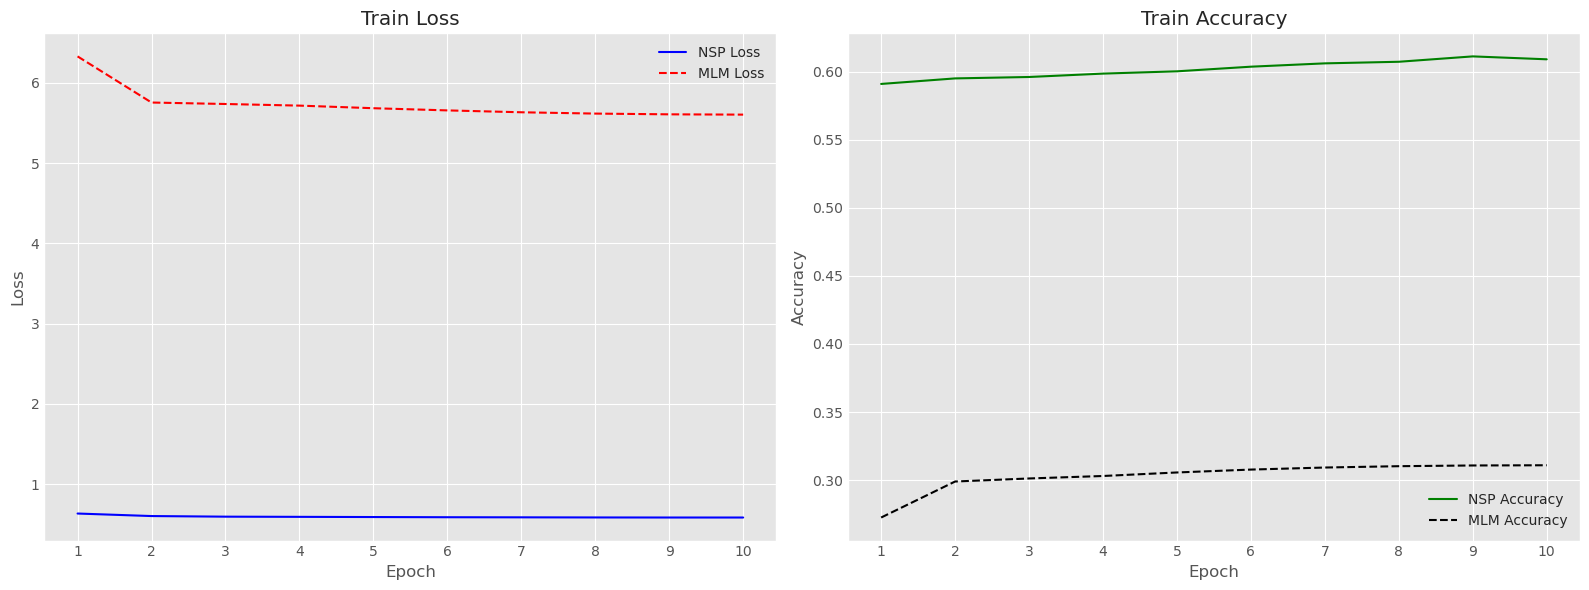

In [28]:
import matplotlib.pyplot as plt

# 훈련 결과 시각화
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 손실(Loss) 그래프
axes[0].plot(history['nsp_loss'], 'b-', label='NSP Loss')
axes[0].plot(history['mlm_loss'], 'r--', label='MLM Loss')
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xticks(range(epochs))
axes[0].set_xticklabels(range(1, epochs + 1))

# 정확도(Accuracy) 그래프
axes[1].plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
axes[1].plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
axes[1].set_title('Train Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_xticks(range(epochs))
axes[1].set_xticklabels(range(1, epochs + 1))

plt.tight_layout()
plt.show()